Revert Prediction Analysis - Solvejg
===

Revert prediction analysis notebook created by Solvejg. Contains an initial comparison of the predictions of the revert models for different revert outcomes.

The filenames of the predictions give, respectively, the max features (not confirmed), the tree depth (not confirmed), the revert start time (in seconds) and the revert end time (in seconds).  In other words, a revision is considered reverted if it was reverted between start time and end time seconds after it was published.

Multiple follow-up analyses to do here. The core question that I would want to answer by sampling of revisions is: comparing the revisions that DON'T change outcome between two similar models, what revisions have a huge change in score? (Is there some particular quality of those revisions that the model is doing better or worse on?)  In general, need to use the actual revert labels (which are in the prediction dataframes) to figure out the performance of the models (including on the subset of revisions with a consistent revert behavior for some subset of models).  To be clear, we don't even know if there are big performance differences between the models.

In [1]:
import numpy as np
import pandas as pd

import os
from tqdm import tqdm
import bz2
import sqlite3
import difflib
import gzip
import json
import re
import hashlib
from datetime import datetime
from datetime import timezone
import scipy.stats

import matplotlib.pyplot as plt
from itertools import combinations

In [2]:
# load predictions
pred_dir = '/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/audit/predictions'

pred_0_30 = pd.read_pickle(os.path.join(pred_dir, 'GB_50_5_0_30_prediction_2020-08-01.pkl'))
pred_0_300 = pd.read_pickle(os.path.join(pred_dir, 'GB_50_5_0_300_prediction_2020-08-01.pkl'))
pred_0_7200 = pd.read_pickle(os.path.join(pred_dir, 'GB_50_5_0_7200_prediction_2020-08-01.pkl'))
pred_0_172800 = pd.read_pickle(os.path.join(pred_dir, 'GB_50_5_0_172800_prediction_2020-08-01.pkl'))
pred_0_604800 = pd.read_pickle(os.path.join(pred_dir, 'GB_50_5_0_604800_prediction_2020-08-01.pkl'))
pred_0_2592000 = pd.read_pickle(os.path.join(pred_dir, 'GB_50_5_0_2592000_prediction_2020-08-01.pkl'))
pred_30_7200 = pd.read_pickle(os.path.join(pred_dir, 'GB_50_5_30_7200_prediction_2020-08-01.pkl'))
pred_7200_2592000 = pd.read_pickle(os.path.join(pred_dir, 'GB_50_5_7200_2592000_prediction_2020-08-01.pkl'))
pred_30_600000000 = pd.read_pickle(os.path.join(pred_dir, 'GB_50_5_30_600000000_prediction_2020-08-01.pkl'))
pred_300_600000000 = pd.read_pickle(os.path.join(pred_dir, 'GB_50_5_300_600000000_prediction_2020-08-01.pkl'))
pred_7200_600000000 = pd.read_pickle(os.path.join(pred_dir, 'GB_50_5_7200_600000000_prediction_2020-08-01.pkl'))
pred_2592000_600000000 = pd.read_pickle(os.path.join(pred_dir, 'GB_50_5_2592000_600000000_prediction_2020-08-01.pkl'))

pred_df_dict = {'0-30 sec': pred_0_30, '0-5 min': pred_0_300, '0-2 hr': pred_0_7200, '0-48 hr': pred_0_172800, '0-7 days': pred_0_604800, '0-30 days': pred_0_2592000, '30 sec-2 hr': pred_30_7200, '2 hr-30 days': pred_7200_2592000, '>= 30 sec': pred_30_600000000, '>= 5 min': pred_300_600000000, '>= 2 hr': pred_7200_600000000, '>= 30 days': pred_2592000_600000000}

In [3]:
# classify predicted probabilities
for label in pred_df_dict:
    df = pred_df_dict[label]
    df['test_pred'] = np.where(df['test_calib'] >= .5, True, False)
    df['test_pred'] = np.where(df['test_calib'] >= .5, True, False)

### Pairwise comparison of time thresholds: all pairs

In [4]:
nochg_all = pd.DataFrame()
chg_all = pd.DataFrame()

for pair in combinations(pred_df_dict, 2):
    x_df = pred_df_dict[pair[0]]
    y_df = pred_df_dict[pair[1]]
    new_df = pd.DataFrame()
    
    new_df['diff'] = abs(x_df['test_calib'] - y_df['test_calib'])
    new_df['outcomechg'] = np.where(x_df['test_label'] != y_df['test_label'], True, False)
    new_chg = new_df[new_df['outcomechg']]
    new_nochg = new_df[new_df['outcomechg']==False]
    
    label = pair[0] + '_' + pair[1]
    nochg_row = {'pair': label, 'diff_mean': new_nochg['diff'].mean(), 'diff_sd': new_nochg['diff'].std(), 'diff_med': new_nochg['diff'].median(), 'diff_max': new_nochg['diff'].max(), 'diff_min': new_nochg['diff'].min()}
    chg_row = {'pair': label, 'diff_mean': new_chg['diff'].mean(), 'diff_sd': new_chg['diff'].std(), 'diff_med': new_chg['diff'].median(), 'diff_max': new_chg['diff'].max(), 'diff_min': new_chg['diff'].min()}
    
    nochg_all = nochg_all.append(nochg_row, ignore_index = True)
    chg_all = chg_all.append(chg_row, ignore_index = True)

In [5]:
nochg_all.sort_values(by = 'diff_mean', ascending = False)

,diff_max,diff_mean,diff_med,diff_min,diff_sd,pair
4,0.854235,0.073263,0.028812,0.000000e+00,0.101316,0-30 sec_0-30 days
62,0.942613,0.072889,0.030899,1.618433e-06,0.097160,>= 30 sec_>= 30 days
3,0.859153,0.071438,0.027370,0.000000e+00,0.100806,0-30 sec_0-7 days
50,0.999853,0.071387,0.028266,7.832085e-07,0.101554,0-30 days_>= 30 days
44,0.999853,0.069649,0.026841,9.712246e-07,0.101149,0-7 days_>= 30 days
...,...,...,...,...,...,...
10,0.905188,0.007220,0.000304,4.847704e-10,0.032014,0-30 sec_>= 30 days
31,0.198519,0.006749,0.004681,0.000000e+00,0.006654,0-48 hr_0-30 days
30,0.164146,0.004513,0.002716,0.000000e+00,0.004992,0-48 hr_0-7 days
38,0.305050,0.002961,0.001823,0.000000e+00,0.003450,0-7 days_0-30 days


In [6]:
chg_all.sort_values(by = 'diff_mean', ascending = False)

,diff_max,diff_mean,diff_med,diff_min,diff_sd,pair
44,0.999943,0.331812,0.268754,6.102974e-05,0.252115,0-7 days_>= 30 days
37,0.999943,0.331717,0.266203,9.427131e-06,0.253724,0-48 hr_>= 30 days
50,0.999951,0.328470,0.267064,5.288359e-05,0.250110,0-30 days_>= 30 days
29,0.999943,0.314105,0.233123,1.911539e-05,0.261705,0-2 hr_>= 30 days
46,0.982297,0.311960,0.242778,1.100720e-06,0.248050,0-30 days_2 hr-30 days
...,...,...,...,...,...,...
53,0.551804,0.044433,0.036769,1.797363e-07,0.036378,30 sec-2 hr_>= 5 min
31,0.160111,0.011901,0.010967,1.507654e-07,0.008078,0-48 hr_0-30 days
30,0.107537,0.008227,0.007211,1.272635e-08,0.006082,0-48 hr_0-7 days
38,0.136500,0.004894,0.003782,2.526767e-07,0.004543,0-7 days_0-30 days


### Pairwise comparisons of time thresholds: One pair at a time

In [7]:
# create new df with rev ids, predictions, and pairwise comparisons
df_1 = '0-30 sec'
df_2 = '0-5 min'

prediction_df = pred_df_dict[df_1].merge(pred_df_dict[df_2], on = 'rev_id', suffixes = ('_'+df_1, '_'+df_2))

prediction_df['diff'] = abs(prediction_df['test_calib_' + df_1] - prediction_df['test_calib_' + df_2])
prediction_df['outcomechg'] = np.where(prediction_df['test_label_' + df_1] != prediction_df['test_label_' + df_2], True, False)
prediction_df.head()

,test_calib_0-30 sec,test_label_0-30 sec,rev_id,test_pred_0-30 sec,test_calib_0-5 min,test_label_0-5 min,test_pred_0-5 min,diff,outcomechg
0,0.000179,False,857219031,False,0.004065,False,False,0.003886,False
1,0.009699,False,857219035,False,0.057606,False,False,0.047907,False
2,0.069794,True,857219034,False,0.199072,True,False,0.129279,False
3,0.000178,False,857219036,False,0.000890,False,False,0.000712,False
4,0.000024,False,857219037,False,0.000302,False,False,0.000277,False


#### Summary statistics for revisions that DID NOT change labeled outcome

In [8]:
nochg = prediction_df[prediction_df['outcomechg']==False]

In [9]:
# difference in predicted probability of revert = True
nochg['diff'].describe()

count    1.149581e+07
mean     1.851935e-02
std      4.231409e-02
min      0.000000e+00
25%      9.366229e-04
50%      3.234959e-03
75%      1.525286e-02
max      7.479328e-01
Name: diff, dtype: float64

In [10]:
nochg['diff'].median()

0.003234959309412027

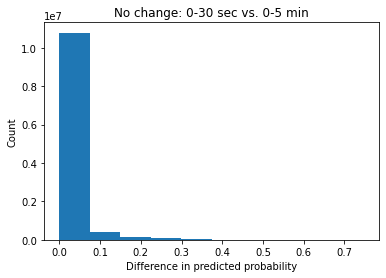

In [11]:
# distribution of differences in predicted probability
n, bins, patches = plt.hist(nochg['diff'], density = False)
plt.xlabel('Difference in predicted probability')
plt.ylabel('Count')
plt.title('No change: ' + df_1 + ' vs. ' + df_2)
plt.show()

In [12]:
# revisions with the largest difference in predicted probability
nochg.sort_values(by = 'diff', axis = 0, ascending = False).head()

,test_calib_0-30 sec,test_label_0-30 sec,rev_id,test_pred_0-30 sec,test_calib_0-5 min,test_label_0-5 min,test_pred_0-5 min,diff,outcomechg
6255719,0.038211,False,867333477,False,0.786144,False,True,0.747933,False
5940859,0.030820,True,866815678,False,0.659497,True,True,0.628676,False
11066955,0.096168,False,875191966,False,0.699520,False,True,0.603352,False
10716505,0.192374,True,874615532,False,0.791718,True,True,0.599343,False
9760009,0.017895,False,873042519,False,0.566983,False,True,0.549087,False


#### Summary statistics for revisions that DID change labeled outcome

In [13]:
chg = prediction_df[prediction_df['outcomechg']]

In [14]:
# difference in predicted probability of revert = True
chg['diff'].describe()

count    242533.000000
mean          0.119696
std           0.102008
min           0.000014
25%           0.034911
50%           0.088083
75%           0.186662
max           0.653426
Name: diff, dtype: float64

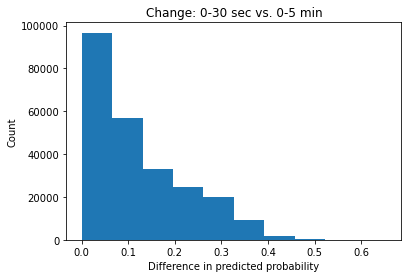

In [15]:
# distribution of differences in predicted probability
n, bins, patches = plt.hist(chg['diff'], density = False)
plt.xlabel('Difference in predicted probability')
plt.ylabel('Count')
plt.title('Change: ' + df_1 + ' vs. ' + df_2)
plt.show()

In [16]:
# revisions with the largest difference in predicted probability
chg.sort_values(by = 'diff', axis = 0, ascending = False).head()

,test_calib_0-30 sec,test_label_0-30 sec,rev_id,test_pred_0-30 sec,test_calib_0-5 min,test_label_0-5 min,test_pred_0-5 min,diff,outcomechg
8588569,0.108188,False,871078582,False,0.761614,True,True,0.653426,True
3320740,0.201714,False,862594490,False,0.825006,True,True,0.623293,True
10887061,0.096168,False,874900990,False,0.699520,True,True,0.603352,True
475277,0.226797,False,858005652,False,0.819933,True,True,0.593136,True
3991508,0.240077,False,863697337,False,0.804464,True,True,0.564386,True
